In [2]:
# Imports
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import csv
import visJS2jupyter.visualizations as visualizations
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap
from networkx.algorithms import community
from bokeh.models import EdgesAndLinkedNodes, NodesAndLinkedEdges
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

#### Data Cleaning

In [3]:
# cleaning and preparing dataframe
def clean_df(df):
  df.columns = df.columns.str.replace(r'_nonpart_part', '')
  df1 = df.copy()
  df1['index'] = df1.index
  contact_type_list = ['index', 'friend',	'workmate',	'neighbour',	'familymember',	'partner',	'colleague_association',	'other']
  df1 = df1[contact_type_list]
  df1 = df1.set_index('index').dot(df1.columns[1:] + ', ').str[:-2].reset_index(name='contact_type')
  df_all = pd.concat([df, df1], axis = 1)
  final_columns = ['sender_id','receiver_id','contact_type','frequency','contact_years','trust']
  final_df = df_all.assign(**{col : 'NA' for col in final_columns if col not in df_all.columns})[final_columns]
  final_df = final_df[['sender_id','receiver_id','contact_type','frequency','contact_years','trust']]
  final_df = final_df[final_df['sender_id'].notna()]
  final_df = final_df[final_df['receiver_id'].notna()]
  final_df['sender_id'] = final_df['sender_id'].astype(int)
  final_df['receiver_id'] = final_df['receiver_id'].astype(int)
  final_df['trust'] = final_df['trust'].fillna(0.2)
  final_df['trust'] = np.where(final_df['trust'] == 'NA', 0.2, final_df['trust'])
  final_df['trust'] = pd.to_numeric(final_df['trust'])
  return final_df 

##### Farmers Network Datasets

In [4]:
# There are 4 datasets of the farmers network, sectioned in the following: 

# agro participating farmers connection
part_part_df = pd.read_csv('data/Edges_agroconcept_complete.csv',sep=";")
part_part_df = clean_df(part_part_df)

# agro participating farmers with external connections- the extrenal connection ID looks similar to farmers ID, have a find a way to filter them
part_others_df = pd.read_csv('data/Edges_agroconcept_and_external_contacts.csv',sep=";")
part_others_df = clean_df(part_others_df)

# non participating farmers with non participating farmers
non_all_df = pd.read_csv('data/Edges_nonpart_all.csv',sep=";")
non_all_df = clean_df(non_all_df)

# non participating farmers with agro participating farmers
non_part_df = pd.read_csv('data/Edges_nonpart_to_agroconcept.csv',sep=";")
non_part_df = clean_df(non_part_df)
non_part_df.head(2)

non_all_df.head(2)

,sender_id,receiver_id,contact_type,frequency,contact_years,trust
0,57,82,"friend, workmate",3.0,NaN,4.0
1,57,83,workmate,2.0,NaN,4.0


In [5]:
# There are 2 datasets that provide us with a list of participating and non-participating farmers and their attributes

# agro participating farmers ID
att_part_df = pd.read_csv('data/Atts_agroconcept_int.csv',sep=";")
part_list = att_part_df['ego_id'].tolist()

# agro participating farmers ID
att_non_df = pd.read_csv('data/Atts_nonpart_int.csv',sep=";")
non_list = att_non_df['ego_id_nonpart'].tolist()
print(part_list, non_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 26, 27, 28] [57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]


##### Combining All 4 Network Data

In [9]:
all_farmers_df = pd.concat([part_part_df, part_others_df, non_all_df, non_part_df])
all_farmers_df['participating'] = np.where( all_farmers_df['sender_id'].isin(part_list),'Yes'
, np.where((all_farmers_df['sender_id'].isin(non_list)) & (~all_farmers_df['sender_id'].isin(part_list)), 'No', 'Others' ))
# all_farmers_df.isna().sum() # checking if there are null values in sender_id or receiver_id columns
all_farmers_df = all_farmers_df.drop_duplicates(subset=['sender_id','receiver_id'])
all_farmers_df.head()

,sender_id,receiver_id,contact_type,frequency,contact_years,trust,participating
0,1,2,colleague_association,1.0,NA,4.0,Yes
1,1,20,"workmate, colleague_association",2.0,NA,4.0,Yes
2,1,26,"workmate, colleague_association",1.0,NA,4.0,Yes
3,1,14,"workmate, colleague_association",2.0,NA,4.0,Yes
4,1,15,"workmate, neighbour, colleague_association",2.0,NA,4.0,Yes


#### Networks Statistics for All 4 Datasets

In [10]:
# Nodes Centrality Statistics
part_part_G = nx.from_pandas_edgelist(part_part_df, 'sender_id', 'receiver_id', edge_attr='trust')
part_others_G = nx.from_pandas_edgelist(part_others_df, 'sender_id', 'receiver_id', edge_attr='trust')
non_part_G = nx.from_pandas_edgelist(non_part_df, 'sender_id', 'receiver_id', edge_attr='trust')
non_all_G = nx.from_pandas_edgelist(non_all_df, 'sender_id', 'receiver_id', edge_attr='trust')

def stats(networkx_G):
    bc = nx.betweenness_centrality(networkx_G)
    cc = nx.closeness_centrality(networkx_G)
    dc = nx.degree_centrality(networkx_G)
    df1 = pd.DataFrame([bc, cc, dc], index = ['Betweenness','Closeness','Degree']).transpose()
    df2 = df1.sort_values(by=["Degree","Closeness","Betweenness"],ascending=[False,False,False])
    return df2

part_part_stats = stats(part_part_G)
part_others_stats = stats(part_others_G)
non_part_stats = stats(non_part_G)
non_all_stats = stats(non_all_G)

n = 8
print(f"Top {n} Highest Connectivity amongst Participating Farmers:", part_part_stats[:n].index.to_list())
print(f"Top {n} Highest Connectivity Participating Farmers with Other Contacts:", part_others_stats[:n].index.to_list())
print(f"Top {n} Highest Connectivity Non-participating with Participating Farmers:", non_part_stats[:n].index.to_list())
print(f"Top {n} Highest Connectivity Non-participating Farmers with All:", non_all_stats[:n].index.to_list())


Top 8 Highest Connectivity amongst Participating Farmers: [14, 12, 19, 20, 9, 18, 1, 7]
Top 8 Highest Connectivity Participating Farmers with Other Contacts: [14, 26, 12, 1, 27, 18, 19, 20]
Top 8 Highest Connectivity Non-participating with Participating Farmers: [79, 76, 78, 60, 27, 17, 68, 59]
Top 8 Highest Connectivity Non-participating Farmers with All: [79, 76, 78, 60, 59, 27, 68, 17]


##### Network Graph Preparation

In [11]:
#Exclude some nodes to focus the network graph better
exclude_nodes = []
cc_dict = nx.closeness_centrality(non_all_G)
for k,v in cc_dict.items():
    if v < 0.2: 
        exclude_nodes.append(k)
node_list_len = len(exclude_nodes)
print(f"Excluded Nodes with {node_list_len} Minimum Closeness Centrality in Non-participating Farmers Network: ", exclude_nodes)

for node in exclude_nodes:
    non_all_G.remove_node(node)
# non_all_G.nodes()

Excluded Nodes with 20 Minimum Closeness Centrality in Non-participating Farmers Network:  [82, 83, 84, 85, 86, 94, 95, 96, 80, 97, 104, 105, 81, 109, 110, 111, 112, 113, 114, 115]


In [12]:
part_colour = dict.fromkeys(all_farmers_df.receiver_id.tolist() + all_farmers_df.sender_id.tolist())
for key, value in part_colour.items():
    # print(key, value)
    if key in part_list:
        part_colour[key] = '#a4d2d0' # green
    elif key in non_list:
        part_colour[key] = '#d2a4a6' # red
    else:
        part_colour[key] = '#e9e3ae' # yellow   


def colour_mapping(G):
    colour_list =[]
    for node in G.nodes():
        colour_list.append(part_colour[node])
    return colour_list

def edge_color(G):
    colour_list =[]
    widths = nx.get_edge_attributes(G, 'trust')
    trust_list = list(widths.values())
    for trust in trust_list:
        if trust >= 1 and trust < 4: #1,2,3
            colour_list.append('#09223a') #dark
        elif trust == 4: 
            colour_list.append('#89bbec') #lighter
        elif trust == 5: 
            colour_list.append('#2075c7') #light
        else: 
            colour_list.append('#0b2742')
    return colour_list

#### Network Graphs of All 4 Categories

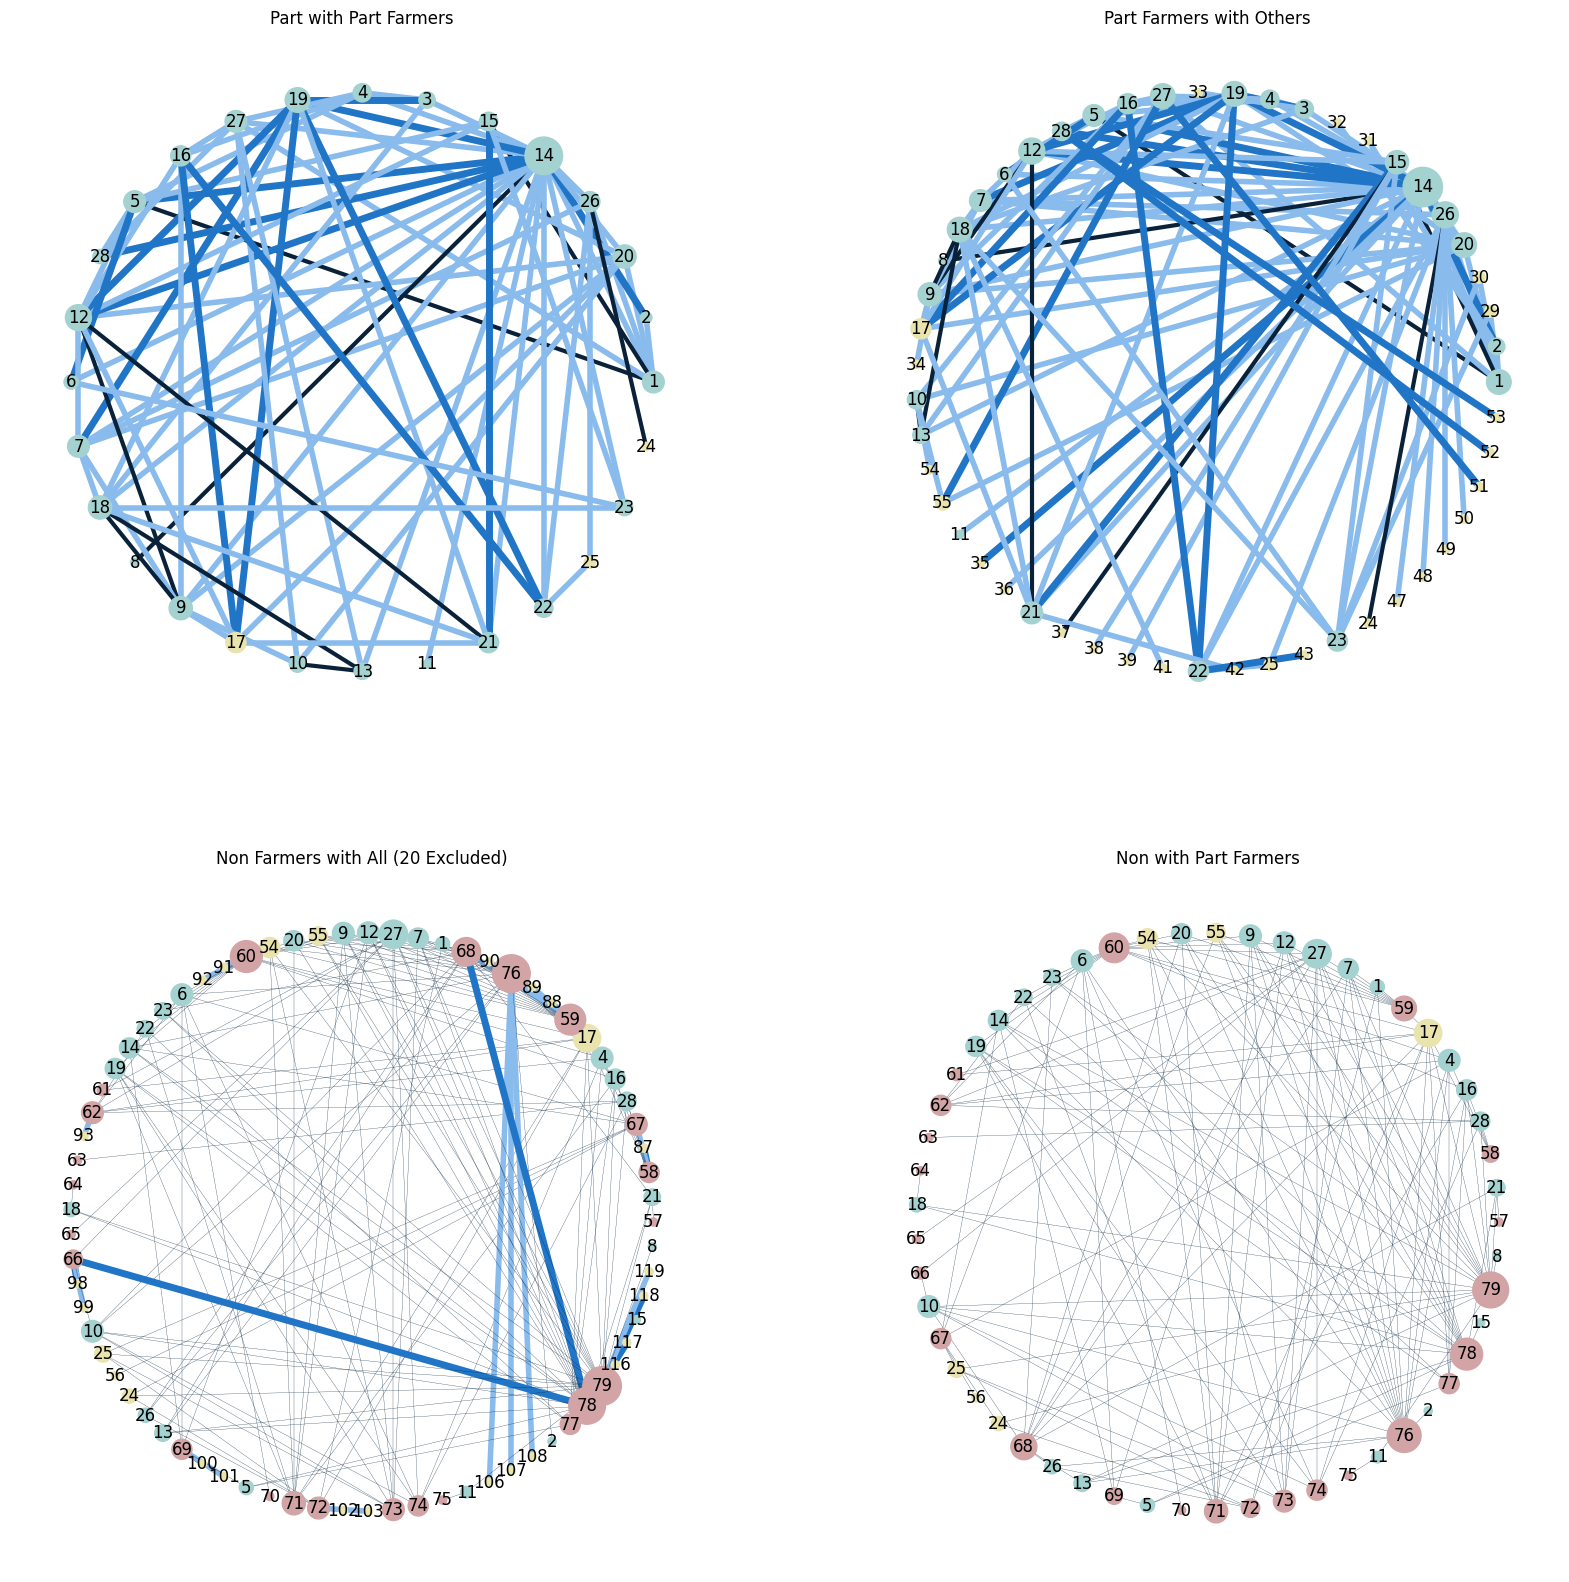

In [13]:
graphs = [part_part_G, part_others_G, non_all_G, non_part_G]
titles = ['Part with Part Farmers', 'Part Farmers with Others', f'Non Farmers with All ({node_list_len} Excluded)', 'Non with Part Farmers']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
ax = axes.flatten()

for i in range(4):
    widths = nx.get_edge_attributes(graphs[i], 'trust')
    nx.draw_networkx(graphs[i], pos=nx.circular_layout(graphs[i]),
    with_labels=True,
    node_color=colour_mapping(graphs[i]),
    node_size=list(dict([(node, degree*35) for node, degree in nx.degree(graphs[i])]).values()),
    font_size=12,
    edge_color=edge_color(graphs[i]),
    width=list(widths.values()),
    ax=ax[i])
    ax[i].set_title(titles[i])
    ax[i].set_axis_off()

plt.show()

#### Interactive Network Graph for All Farmers and Contacts

We have used the reference from https://melaniewalsh.github.io/Intro-Cultural-Analytics/06-Network-Analysis/02-Making-Network-Viz-with-Bokeh.html#network-with-responsive-highlighting for the following visualizations. 

In [16]:
G = nx.from_pandas_edgelist(all_farmers_df, 'sender_id', 'receiver_id', edge_attr='trust')

# Calculate degree for each node and add as node attribute
degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='degree', values=degrees)

# Slightly adjust degree so that the nodes with very small degrees are still visible
number_to_adjust_by = 5
adjusted_node_size = dict([(node, degree+number_to_adjust_by) for node, degree in nx.degree(G)])
nx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

# Calculate communities
communities = greedy_modularity_communities(G)
communities = communities[:-1]

# Create empty dictionaries
modularity_class = {}
# modularity_color = {}
#Loop through each community in the network
for community_number, community in enumerate(communities):
    #For each member of the community, add their community number and a distinct color
    for name in community: 
        modularity_class[name] = community_number
        # modularity_color[name] = Spectral8[community_number]

# Add modularity class and color as attributes from the network above
nx.set_node_attributes(G, modularity_class, 'modularity_class')
nx.set_node_attributes(G, part_colour, 'part_colour')

#Choose colors for node and edge highlighting
node_highlight_color = 'white'
edge_highlight_color = 'black'

#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'part_colour'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8

#Choose a title!
title = 'All Farmers Network'


#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("Farmer ID", "@index"),
        ("Degree", "@degree"),
        #  ("Modularity Class", "@modularity_class"),
        # ("Participating Color", "$color[swatch]:part_colour"),
        # ("Trust", "@trust"),
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)
#Set node highlight colors
network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)
#Set edge highlight colors
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)

#Highlight nodes and edges
network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(network_graph)

show(plot)
# save(plot, filename=f"{title}.html")
output_notebook()

Loading BokehJS ...